Text(0.5, 0, 'Strain')

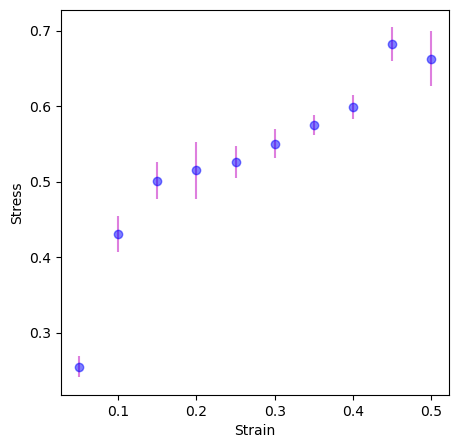

In [1]:
# Display Data
import numpy as np
import pandas as pd

# Read the csv file using pandas
df = pd.read_csv('MData.csv')

# Convert the dataframe to a 3D numpy array
array_3d = np.array([df.values.tolist()])
strain = array_3d[0,:,0]
stress = array_3d[0,:,1]
sd = array_3d[0,:,2]

import matplotlib.pyplot as plt
#Plot Strain-Stress Scatter Graph.
fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [2]:
df

,Strain,mean,sd
0,0.05,0.254823,0.014003
1,0.10,0.430447,0.024344
2,0.15,0.501413,0.024461
3,0.20,0.514713,0.037729
4,0.25,0.526133,0.021151
5,0.30,0.550443,0.018979
6,0.35,0.574680,0.013103
7,0.40,0.598780,0.016494
8,0.45,0.681987,0.022528
9,0.50,0.662970,0.036526


In [3]:
from pylab import * 
import scipy.optimize

def uniaxial_stress(model, trueStrainVec, params):
 """Compressible uniaxial loading. Returns true stress. 
 N: "ture" means add a exp() term on the strain.
 N: model() calls the hyperelastic model, defined below."""
 stress = zeros(len(trueStrainVec))
 for i in range(len(trueStrainVec)):
  lam1 = 1+trueStrainVec[i] #N: convert strain to stretch
  x0 = 1.1/sqrt(lam1)

  calcS22Abs = lambda x: abs( model(lam1,x,x,params)[1,1] )
  #N:The calcS22Abs function is a lambda function that takes 
  #one argument x and returns the absolute value of 
  #the element S22 of the stress tensor, computed by the 
  #model function for a given stretch tensor [lam1,x,x] and params.
  #N:[1,1] is used to access the element in the second row 
  #and second column of the stress tensor (S22)
  # search for transverse stretch that gives S22=0
  lam2 = scipy.optimize.fmin(calcS22Abs, x0, xtol=1e-9, ftol=1e-9, disp=False)
  #N: it uses "fmin" to find the unkown two strains, starting
  #the loop with J=1 (x0=1/sqrt(lam1)),instead of defining a 
  #new variable J.
  stress[i] = model(lam1,lam2,lam2, params)[0,0]
  #N:stores the element S11 in the stress array at 
  #the current strain index i
 return stress

/Users/wangchenjie/opt/anaconda3/envs/MDM/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
def NH_3D(stretch1,stretch2,stretch3,param):
 """Neo-Hookean. 3D loading specified by stretches.
 param[0]=mu, param[1]=kappa"""
 stretch2 = stretch2[0]
 stretch3 = stretch3[0]
 #print(stretch2)
 F = array([ [stretch1,0,0],[0,stretch2,0],[0,0,stretch3] ])
 #print(F)
 #print(F.shape)
 J = det(F)
 Fstar = J**(-1/3) * F
 bstar = dot(Fstar, Fstar.T)
 dev_bstar = bstar - trace(bstar)/3 * eye(3)
 return param[0]/J * dev_bstar + param[1]*(J-1) * eye(3)

Text(0.5, 0, 'Strain')

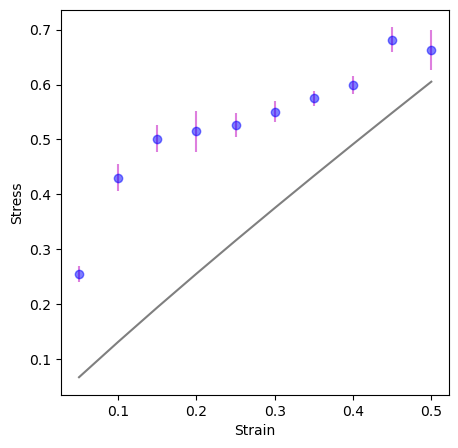

In [5]:
initial_values = [0.5,1.5]
stress_initial_guess = uniaxial_stress(NH_3D, strain, initial_values) 
#mu=param[0],k=mu=param[1]

# Fit the data with deterministic model
fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.plot(strain, stress_initial_guess, 'k', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [6]:
def log_likelihood(param, strain, stress, sd):
    predicted_stress = uniaxial_stress(NH_3D, strain, param)
    residuals = stress - predicted_stress
    
    l=-np.log(sd * np.sqrt(2* np.pi))-((residuals)**2) / (2*sd**2)
    log_likelihood = np.sum(l)
    
    #log_likelihood_value = -0.5 * np.sum((residuals / sd) ** 2) - len(residuals) * np.log(sd * np.sqrt(2 * np.pi))
    return log_likelihood

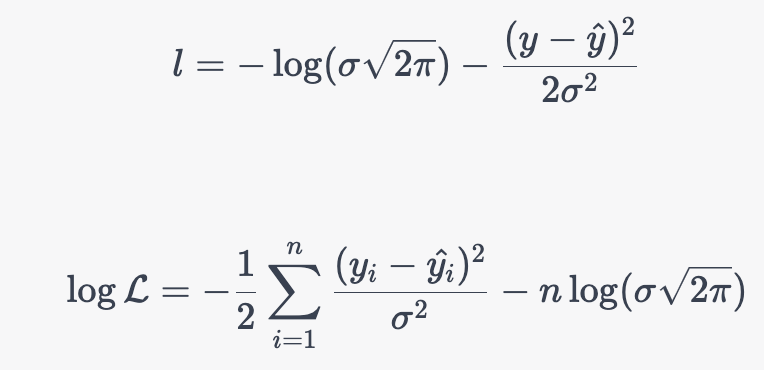

In [7]:
def metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iterations, n_params))
    samples[0] = initial_values
    accepted = np.zeros(n_iterations)
    rejected = np.zeros(n_iterations)

    for i in range(1, n_iterations):
        current_params = samples[i-1]
        proposed_params = current_params + proposal_sds * np.random.randn(n_params)
        log_alpha = log_likelihood(proposed_params, strain, stress, sd) - log_likelihood(current_params, strain, stress, sd)

        if np.random.rand() < min(1, np.exp(log_alpha)):
            samples[i] = proposed_params
            accepted[i] = 1
        else:
            samples[i] = current_params
            rejected[i] = 1

    acceptance_rate = np.sum(accepted) / n_iterations
    return samples, accepted, rejected, acceptance_rate


In [8]:
n_iterations = 5000
initial_values = np.array([0.5, 1.5])
proposal_sds = np.array([0.5, 0.5])
# sd = 0.05  # 假设标准差

samples, accepted, rejected, acceptance_rate = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

print(f"Acceptance rate: {acceptance_rate:.2f}")


Acceptance rate: 0.00


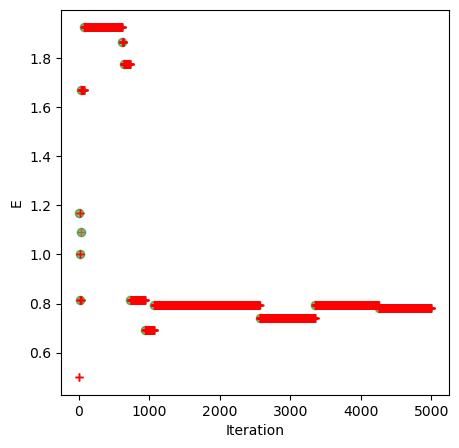

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
#ax.plot(np.arange(n_iterations), samples, alpha=0.5)
ax.plot(np.arange(n_iterations)[accepted==1], samples[accepted==1][:,0], 'go', alpha=0.5)
ax.plot(np.arange(n_iterations)[rejected==1], samples[rejected==1][:,0], 'r+', alpha=0.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('E')
plt.show()

In [10]:
# 要获得参数的最佳估计值，我们可以取样本的均值。同时，为了减少自相关性的影响，我们可以选择仅使用每个链中的第 n 个样本。
burnin = 1000
thinning = 10
samples_thinned = samples[burnin::thinning]
param_mean = np.mean(samples_thinned, axis=0)
print(f"Mean parameter values: {param_mean}")

Mean parameter values: [ 0.77930562 -0.68626681]


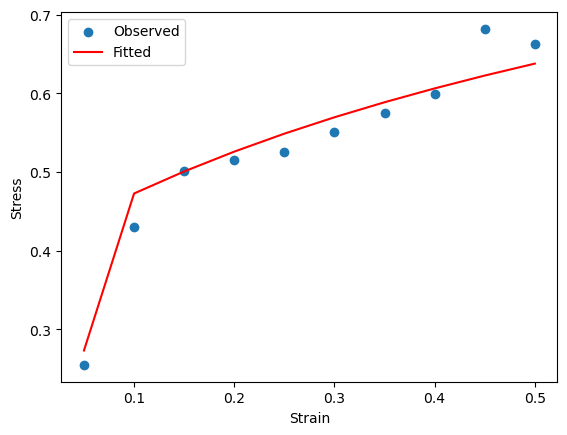

In [11]:
import matplotlib.pyplot as plt

plt.scatter(strain, stress, label='Observed')
predicted_stress = uniaxial_stress(NH_3D, strain, param_mean)
plt.plot(strain, predicted_stress, label='Fitted', color='red')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.legend()
plt.show()


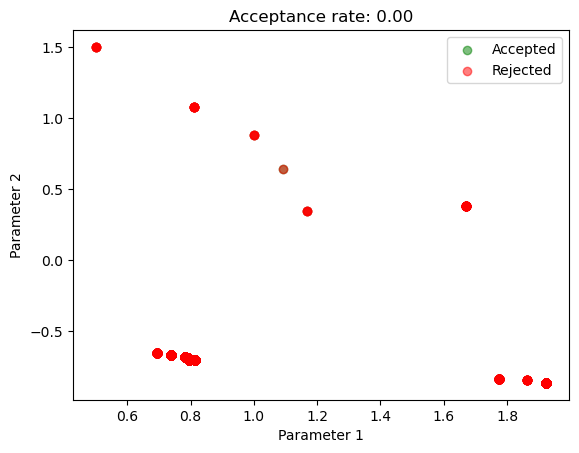

In [12]:
def plot_accepted_rejected(samples, acceptance_rate):
    accepted_samples = [samples[0]]
    rejected_samples = []

    for i in range(1, len(samples)):
        if np.array_equal(samples[i], samples[i-1]):
            rejected_samples.append(samples[i])
        else:
            accepted_samples.append(samples[i])

    accepted_samples = np.array(accepted_samples)
    rejected_samples = np.array(rejected_samples)

    plt.scatter(accepted_samples[:, 0], accepted_samples[:, 1], color='green', label='Accepted', alpha=0.5)
    plt.scatter(rejected_samples[:, 0], rejected_samples[:, 1], color='red', label='Rejected', alpha=0.5)
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.legend()
    plt.title(f"Acceptance rate: {acceptance_rate:.2f}")
    plt.show()

plot_accepted_rejected(samples, acceptance_rate)


[ 0.78228684 -0.68329479]


Text(0.5, 0, 'Strain')

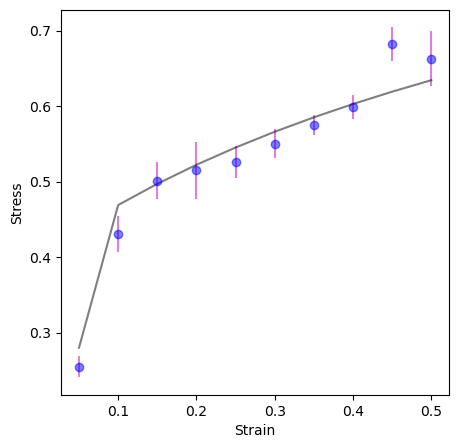

In [13]:
fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
# Plot the trace of the parameters
param = samples[accepted==1][-1]
print(param)
y2 =  uniaxial_stress(NH_3D, strain, param)
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.plot(strain, y2, 'k-', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [14]:
# 去掉前 500 个样本，作为 burn-in
burn_in = 500
samples_after_burn_in = samples[burn_in:]

# 计算均值
mean_params = np.mean(samples_after_burn_in, axis=0)
print(f"Mean parameters: {mean_params}")

# 计算中位数
median_params = np.median(samples_after_burn_in, axis=0)
print(f"Median parameters: {median_params}")

# 计算 95% 置信区间
confidence_interval = np.percentile(samples_after_burn_in, [2.5, 97.5], axis=0)
print(f"95% confidence interval: {confidence_interval}")


Mean parameters: [ 0.83513893 -0.69491526]
Median parameters: [ 0.79221022 -0.68624804]
95% confidence interval: [[ 0.69251665 -0.86390318]
 [ 1.92462121 -0.65054961]]


Correlation Matrix:
[[ 1.         -0.24470159]
 [-0.24470159  1.        ]]


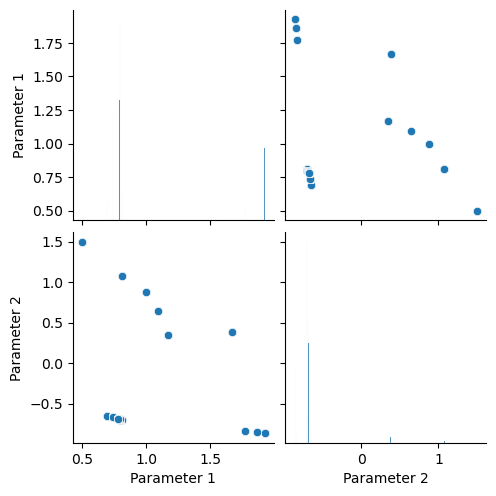

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关系数矩阵
correlation_matrix = np.corrcoef(samples.T)

# 打印相关系数矩阵
print("Correlation Matrix:")
print(correlation_matrix)

# 绘制散点图矩阵
sns.pairplot(pd.DataFrame(samples, columns=['Parameter 1', 'Parameter 2']))
plt.show()
